IMPORT ALL DEPENDECIES

In [4]:
#   ---------  Project Forecast evaluation  ---------
#                  ARMA, ARIMA, SARIMA
#             
#                 ---------------------
#                   SEBASTIAN SUWADA 
#                 ---------------------
#

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import itertools

# ## Ignore Convergence warnings from statsmodels library
import warnings

## Forecasting models imports
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as smapi

IMPORT AND PERPARE DATA FOR ANALYSIS

In [2]:
def prepareData(filename):
    df = pd.read_csv(filename, sep=';')
    data_orginal = df[df['Category'] == 'Furniture'].copy()
    data_orginal = data_orginal[['Order Date','Sales']].set_index('Order Date')
    data_orginal = data_orginal.groupby('Order Date').sum().reset_index()
    data_orginal['Order Date'] = pd.to_datetime(data_orginal['Order Date'])
    resampled = data_orginal.resample('MS', on='Order Date').mean()
    return resampled

## IMPORT DATA
filename = '/Users/sebastiansuwada/Desktop/Predictive Analytics/Project/Code/data.csv'
orginalData = prepareData(filename)


CREATE ROLLING-AVERAGE PLOT AND AUTOCORRELATION PLOT

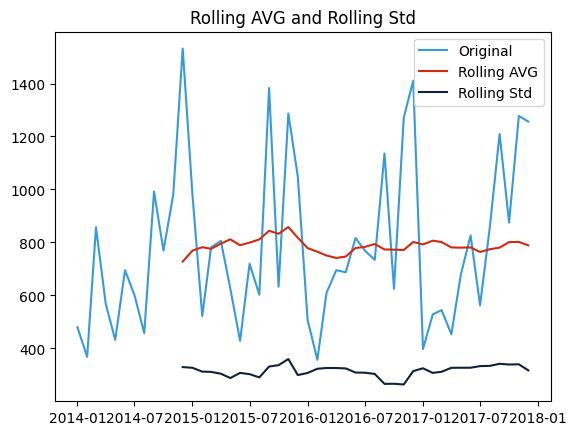

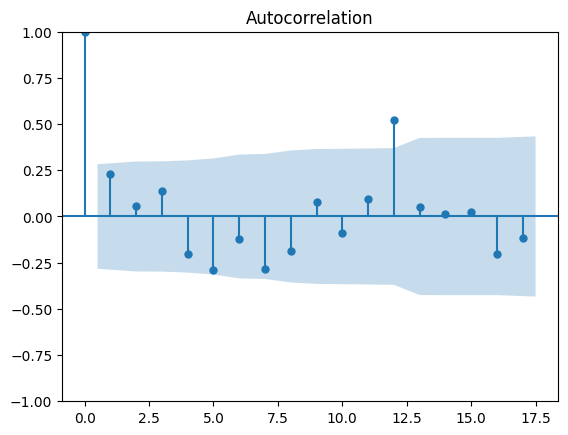

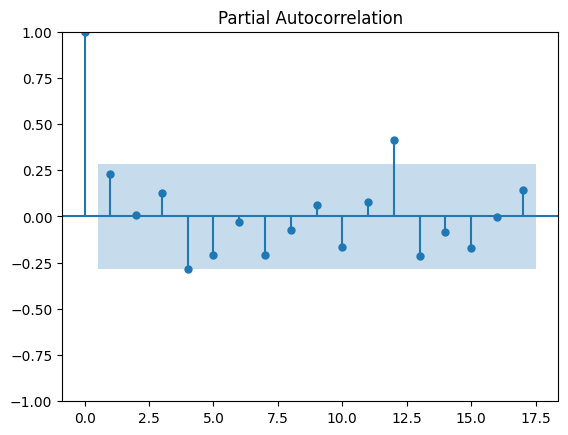

In [5]:
def CreateRolling(data):
    data['RollingAvg'] = data['Sales'].rolling(window=12).mean()
    data['RollingStd'] = data['Sales'].rolling(window=12).std()
    plt.plot(data['Sales'], color='#379BDB', label='Original')
    plt.plot(data['RollingAvg'], color='#D22A0D', label='Rolling AVG')
    plt.plot(data['RollingStd'], color='#142039', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling AVG and Rolling Std')
    plt.show()

def plotAutoCorrelation(data_):
    plot_acf(data_['Sales'])
    plot_pacf(data_['Sales'])
    plt.show()


## PLOT AND CREATE ROLLING MEAN AND STANDARD DEVIATION
CreateRolling(orginalData)

## PLOT AUTOCORRELATION FUNCTION AND PARTIAL AUTOCORRELATION FUNCTION
plotAutoCorrelation(orginalData)

SPLIT DATA INTO TRAINING SET AND EVALUATION SET - 75% Training and 25% evaluation

In [7]:
def trainingDataPrepare(trainSize, data_temp):
    data_temp = orginalData.copy()
    trainData = data_temp[:int(trainSize*len(data_temp))]['Sales']
    testData = data_temp[int(trainSize*len(data_temp)):]['Sales']
    return trainData, testData

## SPLIT DATA INTO TRAINING AND QUALITY CHECK DATA
trainSize = 0.75
trainData, testData = trainingDataPrepare(trainSize, orginalData)

PERFORM ARMA MODEL based on ARIMA (Autoregressive Integrated Moving Average) without Integrated part - first of all needs to define parameters p, q, d -> where p is responsible for Autoregression (AR) part - lag order, q for Moving average (MA) - defines size of moving average window. Last is d what is from Integrated part and defines the number of times the raw observations are differenced. 

In [9]:
def ArmaPrediction(trainData, testData, p ,q, d):
    model = smapi.tsa.arima.ARIMA(trainData,order=(p,d,q)) # when d=0 means that is ARMA bcs I is equal to 0
    modelResults = model.fit()
    ARMAForecast = modelResults.predict(start=testData.index[0], end=testData.index[-1])
    return ARMAForecast

## PERFORM ARMA MODEL
p, q, d = 1, 1, 0
ARMAForecast = ArmaPrediction(trainData, testData, p ,q, d)

CHECK PERFORMANCE FUNCTIONS

======== ARMA FORECAST RESULTS ==========
MSE for ARMA Forecast forecast 111780.55874209735
RMSE for ARMA Forecast forecast 334.3359967788353
MAPE for ARMA Forecast forecast 43.44457869910295


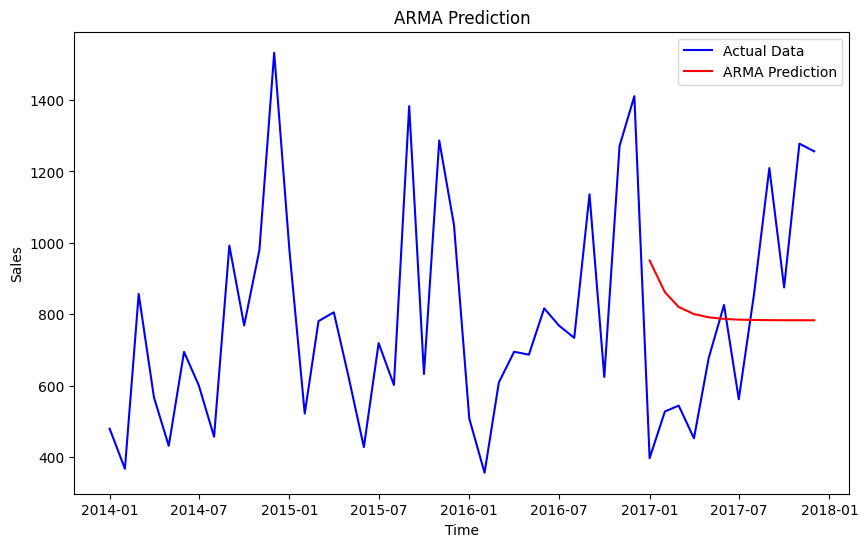

In [11]:
def evaluateForecast(initial, forecast, name_):
    initial_values = np.array(initial)
    forecast_values = np.array(forecast)
    # Mean Squared Error (MSE) and Mean Absolute Percentage Error (MAPE)
    mse = np.mean((initial_values - forecast_values)**2)
    mape = np.mean(np.abs((initial_values - forecast_values) / initial_values)) * 100
    rmse = np.sqrt(mse)
    return mse, mape, rmse

def evaluateForecastPrints(initial, forecast, name_):
    initial_values = np.array(initial)
    forecast_values = np.array(forecast)
    # Mean Squared Error (MSE) and Mean Absolute Percentage Error (MAPE)
    mse = np.mean((initial_values - forecast_values)**2)
    mape = np.mean(np.abs((initial_values - forecast_values) / initial_values)) * 100
    rmse = np.sqrt(mse)
    print('MSE for '+str(name_)+' forecast '+str(mse))
    print('RMSE for '+str(name_)+' forecast '+str(rmse))
    print('MAPE for '+str(name_)+' forecast '+str(mape))

def plotPredictions(forecast, initial, label_):
    plt.figure(figsize=(10, 6))
    plt.plot(initial, label='Actual Data', color='blue')
    plt.plot(forecast, label=label_, color='red')
    plt.title(label_)
    plt.xlabel('Time')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

## CHECK PERFORMANCE OF ARMA
## ARMA EVALUATION
print('======== ARMA FORECAST RESULTS ==========')
evaluateForecastPrints(testData, ARMAForecast, 'ARMA Forecast')
plotPredictions(ARMAForecast, orginalData['Sales'], 'ARMA Prediction')

GRID SEARCH FOR ARIMA PREDICTION

In [12]:
def GridSearchPDQ(trainData, testData, ppos, dpos, qpos):

    best_mse = float('inf')

    for p, d, q in itertools.product(ppos, dpos, qpos):
        try:
            ARIMAForecast = ArmaPrediction(trainData, testData, p, q, d)
            mse, mape, rmse = evaluateForecast(testData, ARIMAForecast, 'ARIMA')
            if mse < best_mse:
                best_mse = mse
                best_params = [p, d, q]
                currBest = ARIMAForecast
        except Exception as e:
            print(f"Error for order ({p}, {d}, {q}): {e}")
            continue
    
    print(f"Combination: p={best_params[0]}, d={best_params[1]}, q={best_params[2]} RMSE = {best_mse}")

    return currBest, best_params

## GRID SEARCH ARIMA
ppos = [0,1,2,3,4,5,6]
dpos = [0,1]
qpos = [0,1]
warnings.filterwarnings("ignore")
ArimaBest, bestParams = GridSearchPDQ(trainData, testData, ppos, dpos, qpos)

Combination: p=6, d=0, q=1 RMSE = 43018.79472941148


BEST RESULTS CALCULATED USING GRID SEARCH ARE: 

p=6, d=0, q=1

PERFORM ARIMA PREDICTION USING PROPOSED PARAMETERS BY AUTHORS OF ARTICLE

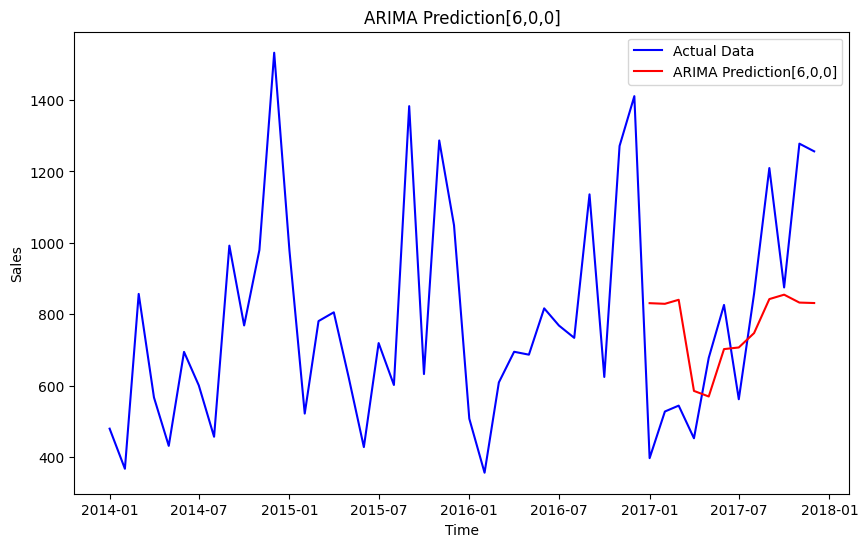

MSE for ARIMA Prediction[6,0,0] forecast 79779.20370553622
RMSE for ARIMA Prediction[6,0,0] forecast 282.4521263958482
MAPE for ARIMA Prediction[6,0,0] forecast 35.04314035640266


In [15]:
## ARIMA p = 6, d = 0, q = 0 - Article Authors decision for ARIMA
p, q, d = 6, 0, 0
ARIMAForecast = ArmaPrediction(trainData, testData, p ,q, d)
plotPredictions(ARIMAForecast, orginalData['Sales'], 'ARIMA Prediction[6,0,0]')
evaluateForecastPrints(testData, ARIMAForecast, 'ARIMA Prediction[6,0,0]')

PERFORM ARIMA PREDICTION USING ESTIMATED PARAMETERS FROM OWN IMPLEMENTATION OF GRID SEARCH

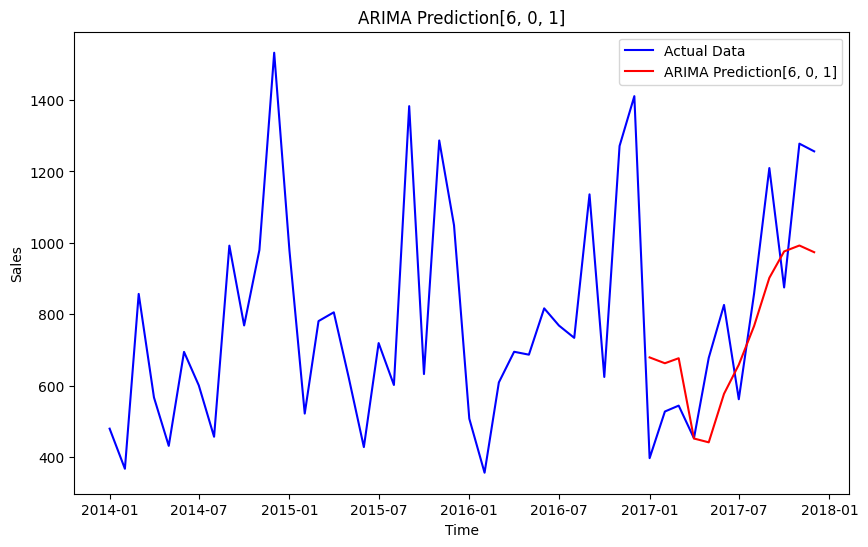

MSE for ARIMA BestParam[6,0,1] forecast 43018.79472941148
RMSE for ARIMA BestParam[6,0,1] forecast 207.40972669913887
MAPE for ARIMA BestParam[6,0,1] forecast 24.614914287667922


In [17]:
## ARIMA PLOT AFTER GRID SEARCH -> Best one d,q (MAX 0 and 1)
plotPredictions(ArimaBest, orginalData['Sales'], 'ARIMA Prediction'+str(bestParams))
evaluateForecastPrints(testData, ArimaBest, 'ARIMA BestParam[6,0,1]')

Check seasonality

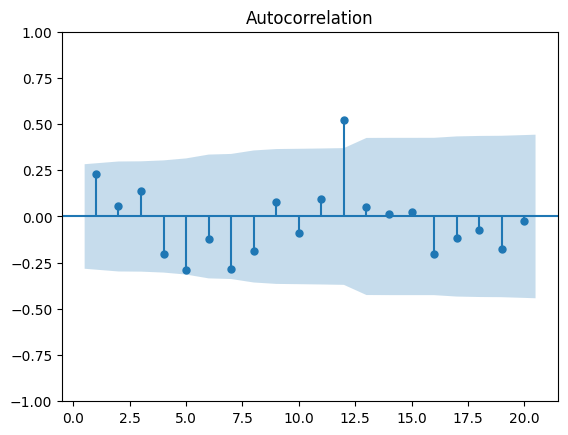

In [18]:
## CHECK SESONALITY - how much lags for seasonal order is needed:
plot_acf(orginalData['Sales'],zero=False,lags=20)
plt.show()

As we can see, there is a seasonal pattern after 12 positions on X axis what represents months. So there is an annual seasonality

SARIMA GRID SEARCH

INITIAL DEFINED RANGE OF VALUES:

ppos = [0]
dpos = [0]
qpos = [0]
Ppos = [0,1]
Dpos = [0,1]
Qpos = [0,1]
m = 12

In both cases evaluated using 'BIC'

In [20]:
def SarimaPrediction(trainData, testData, p ,d, q, P, D, Q, m):
    model = smapi.tsa.statespace.SARIMAX(trainData, order=(p,d,q), seasonal_order=(P,D,Q,m), 
                                         nforce_stationarity=False, enforce_invertibility=False)
    modelResults = model.fit(max_iter=100)
    SARIMAForecast = modelResults.predict(start=testData.index[0], end=testData.index[-1])
    return SARIMAForecast, modelResults

def GridSearchpdqPDQm(trainData, testData, ppos, dpos, qpos, Ppos, Dpos, Qpos, m, compar):

    best_bic = float('inf')

    for p, d, q, P, D, Q in itertools.product(ppos, dpos, qpos, Ppos, Dpos, Qpos):
        try:
            SARIMAForecast, results = SarimaPrediction(trainData, testData, p, d, q, P, D, Q, m)
            if compar == 'aic':
                criterion_value = results.aic
            elif compar == 'bic':
                criterion_value = results.bic

            if criterion_value < best_bic:
                best_bic = criterion_value
                best_params = [p, d, q, P, D, Q]
                currBest = SARIMAForecast
        except Exception as e:
            print(f"Error for order ({p}, {d}, {q}, {P}, {D}, {Q}): {e}")
            continue
    
    print(f"Combination: (p={best_params[0]}, d={best_params[1]}, q={best_params[2]}) (P={best_params[3]}, D={best_params[4]}, Q={best_params[5]}) {compar} = {criterion_value}")

    return currBest, best_params, results

## GRID SEARCH FOR SESONALITY ORDERS - SARIMA

ppos = [0]
dpos = [0]
qpos = [0]
Ppos = [0,1]
Dpos = [0,1]
Qpos = [0,1]
m = 12

SARIMAForecast, SarimaParam, resultsSARIMA = GridSearchpdqPDQm(trainData, testData, ppos, dpos, qpos, Ppos, Dpos, Qpos, m, 'bic')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15153D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   0.000D+00   8.152D+00
  F =   8.1515336770957934     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.0

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.65513D+00    |proj g|=  8.20943D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      5      7      1     0     0   8.209D-07   4.655D+00
  F =   4.6551271922897790     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.65576D+00    |proj g|=  2.60205D-01

At iterate    5    f=  4.58732D+00    |proj g|=  7.70778D-04

At iterate   10    f=  4.58700D+00    |proj g|=  1.66660D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.35880D+00    |proj g|=  6.49706D-05

At iterate   10    f=  7.35876D+00    |proj g|=  1.69713D-03

At iterate   15    f=  7.35869D+00    |proj g|=  1.38796D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     15     21      1     0     0   1.388D-06   7.359D+00
  F =   7.3586918870463496     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05459D+01    |proj g|=  5.06696D+00


 This problem is unconstrained.



At iterate    5    f=  7.48238D+00    |proj g|=  1.04303D-01

At iterate   10    f=  7.34223D+00    |proj g|=  2.41726D-02

At iterate   15    f=  7.33933D+00    |proj g|=  2.78585D-03

At iterate   20    f=  7.33149D+00    |proj g|=  9.38597D-02

At iterate   25    f=  7.26214D+00    |proj g|=  1.11121D-02

At iterate   30    f=  7.26184D+00    |proj g|=  5.58361D-02

At iterate   35    f=  7.26014D+00    |proj g|=  4.26762D-02

At iterate   40    f=  7.25999D+00    |proj g|=  1.05646D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     40     63      1     0     0   1.056D-02   7.260D+00
  F =   7.25999239808

 This problem is unconstrained.
 This problem is unconstrained.


At iterate   15    f=  4.52175D+00    |proj g|=  5.22173D-03

At iterate   20    f=  4.52137D+00    |proj g|=  5.09072D-04

At iterate   25    f=  4.52135D+00    |proj g|=  9.21319D-03

At iterate   30    f=  4.52128D+00    |proj g|=  1.37503D-03

At iterate   35    f=  4.52124D+00    |proj g|=  3.88269D-03

At iterate   40    f=  4.52121D+00    |proj g|=  1.39722D-03

At iterate   45    f=  4.52118D+00    |proj g|=  6.39720D-05

At iterate   50    f=  4.52117D+00    |proj g|=  5.58647D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     75      1     0     0   5.586D-03   4.521D+00
  F =   4.521170994343

Results from GRID SEARCH are

Combination: (p=0, d=0, q=0) (P=1, D=1, Q=0) bic = 335.0584730837658


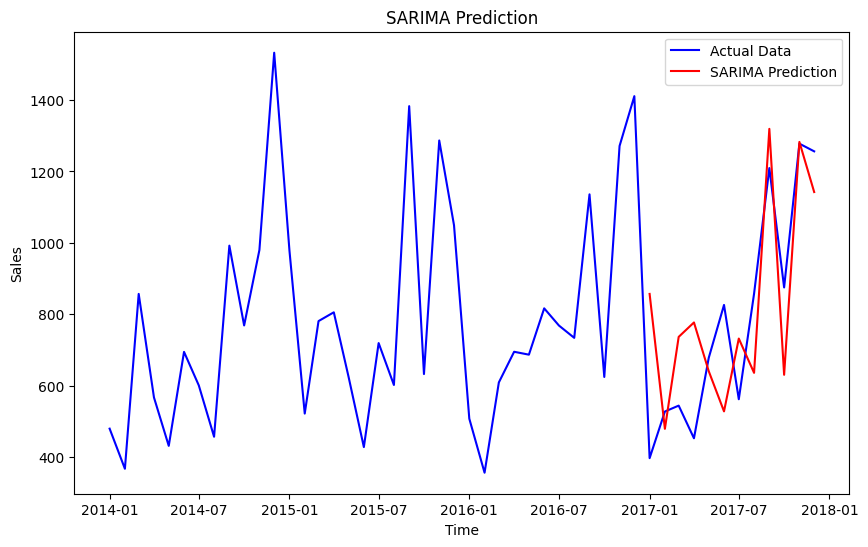

======== SARIMA FORECAST RESULTS ==========
MSE for SARIMA Forecast forecast 50710.98963710692
RMSE for SARIMA Forecast forecast 225.19100700762212
MAPE for SARIMA Forecast forecast 31.29930706171721


In [22]:
## SARIMA PREDICTIONS
plotPredictions(SARIMAForecast, orginalData['Sales'], 'SARIMA Prediction')

print('======== SARIMA FORECAST RESULTS ==========')
evaluateForecastPrints(testData, SARIMAForecast, 'SARIMA Forecast')

GRID SEARCH USING DEFINED RANGE:

ppos = [0, 1]
dpos = [0, 1]
qpos = [0, 1]
Ppos = [0, 1]
Dpos = [0, 1]
Qpos = [0, 1]

Evaluation parameter is 'BIC'

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15153D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   0.000D+00   8.152D+00
  F =   8.1515336770957934     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.0

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.65576D+00    |proj g|=  2.60205D-01

At iterate    5    f=  4.58732D+00    |proj g|=  7.70778D-04

At iterate   10    f=  4.58700D+00    |proj g|=  1.66660D-02

At iterate   15    f=  4.56837D+00    |proj g|=  9.52185D-02

At iterate   20    f=  4.55366D+00    |proj g|=  7.98921D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     21     22      1     0     0   1.958D-06   4.554D+00
  F =   4.5536575972207087     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  7.33933D+00    |proj g|=  2.78585D-03

At iterate   20    f=  7.33149D+00    |proj g|=  9.38597D-02

At iterate   25    f=  7.26214D+00    |proj g|=  1.11121D-02

At iterate   30    f=  7.26184D+00    |proj g|=  5.58361D-02

At iterate   35    f=  7.26014D+00    |proj g|=  4.26762D-02

At iterate   40    f=  7.25999D+00    |proj g|=  1.05646D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     40     63      1     0     0   1.056D-02   7.260D+00
  F =   7.2599923980850685     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.65576D+00    |proj g|=  2.60205D-01

At iterate    5    f=  4.57459D+00    |proj g|=  9.56076D-04

At iterate   10    f=  4.57126D+00    |proj g|=  1.32704D-02

At iterate   15    f=  4.52175D+00    |proj g|=  5.22173D-03

At iterate   20    f=  4.52137D+00    |proj g|=  5.09072D-04

At iterate   25    f=  4.52135D+00    |proj g|=  9.21319D-03

At iterate   30    f=  4.52128D+00    |proj g|=  1.37503D-03

At iterate   35    f=  4.52124D+00    |proj g|=  3.88269D-03

At iterate   40    f=  4.52121D+00    |proj g|=  1.39722D-03

At iterate   45    f=  4.52118D+00    |proj g|=  6.39720D-05

At iterate   50    f=  4.52117D+00    |proj g|=  5.58647D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  7.57008D+00    |proj g|=  8.65277D-02

At iterate   25    f=  7.56043D+00    |proj g|=  7.22221D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     32      1     0     0   2.413D-06   7.560D+00
  F =   7.5604270042863995     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.64847D+00    |proj g|=  2.60095D-02

At iterate    5    f=  4.64804D+00    |proj g|=  5.38075D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  4.56228D+00    |proj g|=  1.03069D-01

At iterate   20    f=  4.54420D+00    |proj g|=  1.68183D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     25      1     0     0   1.147D-06   4.544D+00
  F =   4.5441982657547166     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.34059D+00    |proj g|=  4.93860D-02

At iterate    5    f=  8.10451D+00    |proj g|=  6.59188D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     34     47      1     0     0   5.003D-06   7.283D+00
  F =   7.2826459556071592     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.98564D+00    |proj g|=  3.91947D-01

At iterate    5    f=  7.84543D+00    |proj g|=  1.93597D-02

At iterate   10    f=  7.84497D+00    |proj g|=  2.57940D-03

At iterate   15    f=  7.83627D+00    |proj g|=  3.63596D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  4.51656D+00    |proj g|=  5.55325D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     21      1     0     0   3.446D-07   4.517D+00
  F =   4.5165593642918402     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.64847D+00    |proj g|=  2.64143D-01

At iterate    5    f=  4.56756D+00    |proj g|=  1.16499D-02

At iterate   10    f=  4.56728D+00    |proj g|=  2.94103D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  7.02886D+00    |proj g|=  8.83361D-04

At iterate   10    f=  7.02880D+00    |proj g|=  7.81260D-03

At iterate   15    f=  7.02237D+00    |proj g|=  9.16747D-02

At iterate   20    f=  7.00251D+00    |proj g|=  1.80375D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     22     23      1     0     0   9.243D-06   7.003D+00
  F =   7.0025029923953532     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  6.93500D+00    |proj g|=  3.73098D-03

At iterate   30    f=  6.93375D+00    |proj g|=  1.97899D-02

At iterate   35    f=  6.93327D+00    |proj g|=  1.71709D-02

At iterate   40    f=  6.93303D+00    |proj g|=  1.93802D-02

At iterate   45    f=  6.93293D+00    |proj g|=  1.64855D-02

At iterate   50    f=  6.93286D+00    |proj g|=  2.78827D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     63      1     0     0   2.788D-02   6.933D+00
  F =   6.9328620025351313     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.60942D+00    |proj g|=  2.49463D-01

At iterate    5    f=  4.53352D+00    |proj g|=  2.55375D-03

At iterate   10    f=  4.53342D+00    |proj g|=  3.30374D-03

At iterate   15    f=  4.52787D+00    |proj g|=  8.15416D-03

At iterate   20    f=  4.49650D+00    |proj g|=  1.74403D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     34      1     0     0   3.874D-05   4.496D+00
  F =   4.4964232382961988     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.98563D+00    |proj g|=  3.49457D-01

At iterate    5    f=  6.92083D+00    |proj g|=  8.20203D-04

At iterate   10    f=  6.92026D+00    |proj g|=  2.24054D-02

At iterate   15    f=  6.90470D+00    |proj g|=  7.19391D-02

At iterate   20    f=  6.89483D+00    |proj g|=  3.12578D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     26      1     0     0   1.113D-06   6.895D+00
  F =   6.8948342389741955     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  4.47302D+00    |proj g|=  8.70418D-04

At iterate   10    f=  4.47272D+00    |proj g|=  1.20710D-02

At iterate   15    f=  4.41851D+00    |proj g|=  5.71998D-02

At iterate   20    f=  4.40794D+00    |proj g|=  4.37850D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     26      1     0     0   2.342D-06   4.408D+00
  F =   4.4078999289825394     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.



At iterate    5    f=  6.88594D+00    |proj g|=  1.66912D-02

At iterate   10    f=  6.88447D+00    |proj g|=  5.07506D-03

At iterate   15    f=  6.87455D+00    |proj g|=  9.86740D-02

At iterate   20    f=  6.75250D+00    |proj g|=  3.31540D-02

At iterate   25    f=  6.75223D+00    |proj g|=  2.84860D-03

At iterate   30    f=  6.75179D+00    |proj g|=  4.64512D-04

At iterate   35    f=  6.75141D+00    |proj g|=  2.32076D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f=  6.75135D+00    |proj g|=  5.15461D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     43     91      2     0     0   6.995D-05   6.751D+00
  F =   6.7513448493188477     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.46652D+00    |proj g|=  3.25646D-02

At iterate    5    f=  4.46347D+00    |proj g|=  9.89509D-04

At iterate   10    f=  4.46220D+00    |proj g|=  2.84489D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.34202D+00    |proj g|=  4.53395D-01

At iterate    5    f=  7.24347D+00    |proj g|=  1.30230D-02

At iterate   10    f=  7.23668D+00    |proj g|=  2.97686D-03

At iterate   15    f=  7.23653D+00    |proj g|=  2.11965D-03

At iterate   20    f=  7.22562D+00    |proj g|=  5.12523D-02

At iterate   25    f=  7.20154D+00    |proj g|=  2.10790D-03

At iterate   30    f=  7.20150D+00    |proj g|=  1.16565D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     32     

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.20643D+00    |proj g|=  7.93908D-02

At iterate   10    f=  7.19185D+00    |proj g|=  1.20811D-03

At iterate   15    f=  7.19078D+00    |proj g|=  1.04264D-02

At iterate   20    f=  7.15676D+00    |proj g|=  4.73165D-02

At iterate   25    f=  7.12163D+00    |proj g|=  9.51956D-02

At iterate   30    f=  7.07152D+00    |proj g|=  1.38248D-03

At iterate   35    f=  7.07117D+00    |proj g|=  6.27401D-02

At iterate   40    f=  7.06955D+00    |proj g|=  4.02769D-02

At iterate   45    f=  7.06893D+00    |proj g|=  4.27398D-02

At iterate   50    f=  7.06863D+00    |proj g|=  9.33691D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  4.51154D+00    |proj g|=  9.30605D-03

At iterate   25    f=  4.51147D+00    |proj g|=  5.13953D-03

At iterate   30    f=  4.51121D+00    |proj g|=  1.05548D-02

At iterate   35    f=  4.51105D+00    |proj g|=  1.03506D-02

At iterate   40    f=  4.51096D+00    |proj g|=  1.20830D-02

At iterate   45    f=  4.51090D+00    |proj g|=  5.97572D-03

At iterate   50    f=  4.51087D+00    |proj g|=  6.09425D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     61      1     0     0   6.094D-03   4.511D+00
  F =   4.5108696625248799     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31981D+01    |proj g|=  7.16994D+01

At iterate    5    f=  7.42936D+00    |proj g|=  3.74609D-01

At iterate   10    f=  7.22591D+00    |proj g|=  4.33598D-02

At iterate   15    f=  7.20598D+00    |proj g|=  5.53443D-03

At iterate   20    f=  7.20564D+00    |proj g|=  1.66739D-04

At iterate   25    f=  7.20557D+00    |proj g|=  8.84652D-03

At iterate   30    f=  7.20489D+00    |proj g|=  3.01430D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  4.54176D+00    |proj g|=  1.05834D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     31      1     0     0   1.525D-05   4.542D+00
  F =   4.5417446717018750     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.79900D+00    |proj g|=  1.06330D+00

At iterate    5    f=  7.53450D+00    |proj g|=  6.18981D-02

At iterate   10    f=  7.22674D+00    |proj g|=  5.12349D-01

At iter

 This problem is unconstrained.



At iterate   25    f=  7.08823D+00    |proj g|=  9.92056D-02

At iterate   30    f=  7.04926D+00    |proj g|=  1.54459D-02

At iterate   35    f=  7.04920D+00    |proj g|=  1.16081D-02

At iterate   40    f=  7.04876D+00    |proj g|=  6.45904D-02

At iterate   45    f=  7.04869D+00    |proj g|=  1.73006D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     47     60      1     0     0   1.457D-04   7.049D+00
  F =   7.0486940648070826     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   15    f=  7.08491D+00    |proj g|=  3.08234D-03

At iterate   20    f=  7.08430D+00    |proj g|=  1.31381D-03

At iterate   25    f=  7.08241D+00    |proj g|=  1.51050D-02

At iterate   30    f=  7.00899D+00    |proj g|=  1.28924D-01

At iterate   35    f=  6.97814D+00    |proj g|=  1.44174D-01

At iterate   40    f=  6.96632D+00    |proj g|=  2.63173D-02

At iterate   45    f=  6.96495D+00    |proj g|=  9.71462D-03

At iterate   50    f=  6.96420D+00    |proj g|=  2.84299D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     63      1     0     0   2.843D-02   6.964D+00
  F =   6.96420109084

 This problem is unconstrained.



At iterate   25    f=  4.51369D+00    |proj g|=  2.14118D-02

At iterate   30    f=  4.51231D+00    |proj g|=  1.05922D-02

At iterate   35    f=  4.51170D+00    |proj g|=  1.25549D-02

At iterate   40    f=  4.51150D+00    |proj g|=  2.62238D-02

At iterate   45    f=  4.51145D+00    |proj g|=  2.29433D-03

At iterate   50    f=  4.51142D+00    |proj g|=  2.84535D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     63      1     0     0   2.845D-02   4.511D+00
  F =   4.5114201856063767     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  4.56499D+00    |proj g|=  1.18644D-03

At iterate   15    f=  4.56418D+00    |proj g|=  9.35186D-03

At iterate   20    f=  4.52530D+00    |proj g|=  5.03752D-02

At iterate   25    f=  4.52103D+00    |proj g|=  2.46426D-02

At iterate   30    f=  4.51816D+00    |proj g|=  2.76982D-02

At iterate   35    f=  4.51607D+00    |proj g|=  8.18476D-03

At iterate   40    f=  4.51592D+00    |proj g|=  3.66836D-03

At iterate   45    f=  4.51574D+00    |proj g|=  1.19983D-02

At iterate   50    f=  4.51566D+00    |proj g|=  1.48083D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     63   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.02428D+00    |proj g|=  3.60786D-01

At iterate    5    f=  6.95074D+00    |proj g|=  8.89952D-04

At iterate   10    f=  6.94954D+00    |proj g|=  3.62810D-02

At iterate   15    f=  6.93415D+00    |proj g|=  4.62473D-02

At iterate   20    f=  6.93014D+00    |proj g|=  4.89385D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     26      1     0     0   1.534D-06   6.930D+00
  F =   6.9301396942427242     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  4.45310D+00    |proj g|=  8.31717D-02

At iterate   20    f=  4.44643D+00    |proj g|=  8.00846D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     23      1     0     0   1.834D-05   4.446D+00
  F =   4.4464310778656211     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93749D+00    |proj g|=  7.55392D-02

At iterate    5    f=  6.92643D+00    |proj g|=  1.24920D-03

At iter

 This problem is unconstrained.



At iterate   10    f=  6.91839D+00    |proj g|=  1.47013D-03

At iterate   15    f=  6.91775D+00    |proj g|=  1.44969D-02

At iterate   20    f=  6.87807D+00    |proj g|=  1.52380D-01

At iterate   25    f=  6.83897D+00    |proj g|=  4.10619D-03

At iterate   30    f=  6.83897D+00    |proj g|=  5.22108D-03

At iterate   35    f=  6.83876D+00    |proj g|=  4.54810D-02

At iterate   40    f=  6.83849D+00    |proj g|=  1.35355D-03

At iterate   45    f=  6.83835D+00    |proj g|=  3.41886D-02

At iterate   50    f=  6.83827D+00    |proj g|=  1.71398D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     66   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  4.47255D+00    |proj g|=  4.20822D-03

At iterate   15    f=  4.46388D+00    |proj g|=  2.52699D-02

At iterate   20    f=  4.42742D+00    |proj g|=  7.75174D-03

At iterate   25    f=  4.42734D+00    |proj g|=  4.27430D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     34      1     0     0   4.274D-05   4.427D+00
  F =   4.4273413942229052     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  6.96823D+00    |proj g|=  1.71455D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     34      1     0     0   1.496D-06   6.968D+00
  F =   6.9682327163145636     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.98776D+00    |proj g|=  3.48076D-01

At iterate    5    f=  6.91291D+00    |proj g|=  3.47438D-02

At iterate   10    f=  6.91217D+00    |proj g|=  9.03170D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.52931D+00    |proj g|=  9.13531D-02

At iterate   10    f=  4.52048D+00    |proj g|=  1.50753D-02

At iterate   15    f=  4.52015D+00    |proj g|=  7.70160D-04

At iterate   20    f=  4.51984D+00    |proj g|=  1.64625D-02

At iterate   25    f=  4.51538D+00    |proj g|=  4.21510D-03

At iterate   30    f=  4.51528D+00    |proj g|=  2.19442D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     40      1     0     0   2.194D-06   4.515D+00
  F =   4.5152766856047020     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  6.88171D+00    |proj g|=  2.92620D-03

At iterate   15    f=  6.87622D+00    |proj g|=  5.53033D-02

At iterate   20    f=  6.82007D+00    |proj g|=  1.27897D-01

At iterate   25    f=  6.80781D+00    |proj g|=  1.85959D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     40      1     0     0   5.778D-06   6.808D+00
  F =   6.8078041364122468     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   15    f=  6.87015D+00    |proj g|=  1.37823D-03

At iterate   20    f=  6.86959D+00    |proj g|=  9.17024D-03

At iterate   25    f=  6.84734D+00    |proj g|=  2.53702D-01

At iterate   30    f=  6.75236D+00    |proj g|=  1.93562D-01

At iterate   35    f=  6.73205D+00    |proj g|=  2.38679D-02

At iterate   40    f=  6.73194D+00    |proj g|=  6.38623D-03

At iterate   45    f=  6.73126D+00    |proj g|=  1.57932D-02

At iterate   50    f=  6.73107D+00    |proj g|=  6.61157D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     69      1     0     0   6.612D-02   6.731D+00
  F =   6.73107303651

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     31      1     0     0   4.795D-06   4.365D+00
  F =   4.3645097450696424     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.54310D+00    |proj g|=  2.33420D-01

At iterate    5    f=  4.45304D+00    |proj g|=  7.02146D-03

At iterate   10    f=  4.45282D+00    |proj g|=  9.94702D-04

At iterate   15    f=  4.45219D+00    |proj g|=  2.02948D-02

At iter

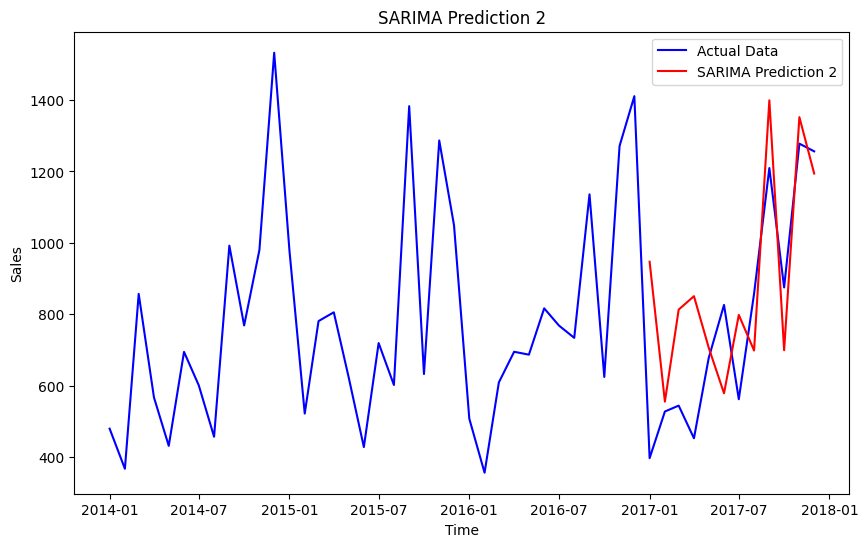

======== SARIMA 2 FORECAST RESULTS ==========
MSE for SARIMA Forecast 2 forecast 62702.21449250149
RMSE for SARIMA Forecast 2 forecast 250.40410238752378
MAPE for SARIMA Forecast 2 forecast 35.13754753354456


In [26]:
ppos = [0, 1]
dpos = [0, 1]
qpos = [0, 1]
Ppos = [0, 1]
Dpos = [0, 1]
Qpos = [0, 1]

SARIMAForecast2BIC, SarimaParam2BIC, resultsSARIMA2BIC = GridSearchpdqPDQm(trainData, testData, ppos, dpos, qpos, Ppos, Dpos, Qpos, m, 'bic')
plotPredictions(SARIMAForecast2BIC, orginalData['Sales'], 'SARIMA Prediction 2')

print('======== SARIMA 2 FORECAST RESULTS ==========')
evaluateForecastPrints(testData, SARIMAForecast2BIC, 'SARIMA Forecast 2')

BEST COMBINATION FOR GREAD SEARCH IS

(p=0, d=1, q=1) (P=1, D=1, Q=0) bic = 329.82742201745657


Seasonal prediction using SARIMA MODEL for next four years

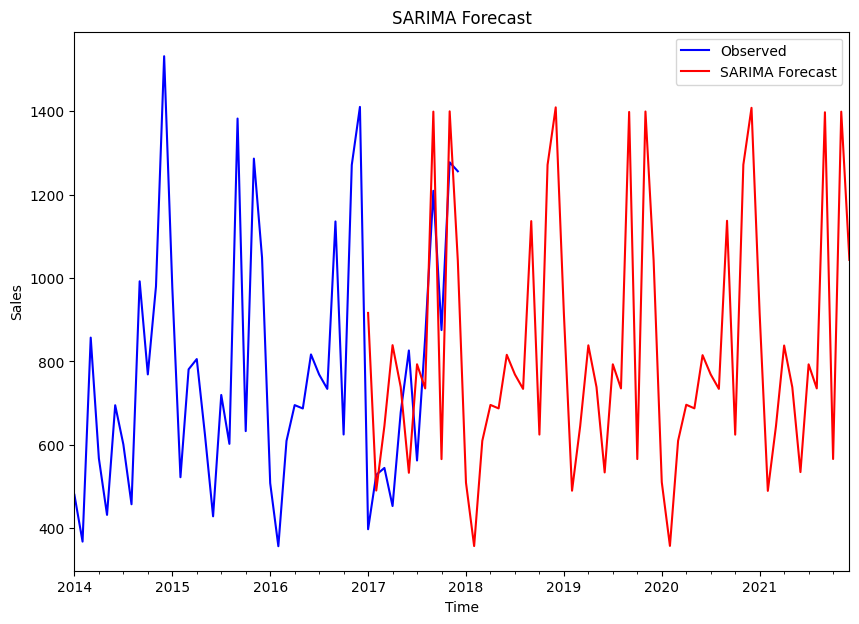

In [27]:
sarimaPlot = orginalData['Sales'].plot(label='Observed', figsize=(10, 7), color='blue')
SarimaForc = resultsSARIMA.get_forecast(steps=60)
SarimaForc.predicted_mean.plot(ax=sarimaPlot, label='SARIMA Forecast', color='red')
sarimaPlot.set_title('SARIMA Forecast')
sarimaPlot.set_xlabel('Time')
sarimaPlot.set_ylabel('Sales')
sarimaPlot.legend(loc='best')
plt.show()

ALL MODELS ON ONE PLOT

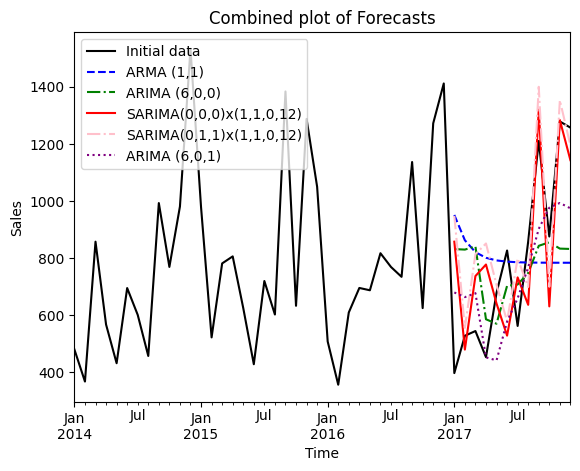

In [28]:
def onePlotAll(sarima, sarima2, arima, arima2 , arma, orginalData, name_):
    plotLabel = orginalData['Sales'].plot(label = 'Initial data', color = 'black')
    #plt.figure(figsize=(16, 9))  # Adjust the figure size as needed
    arma.plot(ax=plotLabel,label='ARMA (1,1)', linestyle= '--',  color='blue')
    arima.plot(ax=plotLabel,label='ARIMA (6,0,0)', linestyle= '-.',  color='green')
    sarima.plot(ax=plotLabel,label='SARIMA(0,0,0)x(1,1,0,12)', linestyle= '-',  color='red')
    sarima2.plot(ax=plotLabel,label='SARIMA(0,1,1)x(1,1,0,12)', linestyle= 'dashdot',  color='pink')
    arima2.plot(ax=plotLabel,label='ARIMA (6,0,1)', linestyle= ':',  color='purple')
    plotLabel.set_xlabel('Time')
    plotLabel.set_ylabel('Sales')
    plotLabel.set_title(name_)
    plotLabel.legend(loc='best')
    # plotLabel.grid(True)
    plt.show()

## PLOT ALL AT ONE GRAPH
onePlotAll(SARIMAForecast, SARIMAForecast2BIC, ARIMAForecast, ArimaBest, ARMAForecast, orginalData, 'Combined plot of Forecasts')


ERRORS OF ALL MODELS EVALUATION

In [30]:
## PRINT ERRORS EVALUATION


## ARMA EVALUATION
print('======== ARMA FORECAST RESULTS ==========')
evaluateForecastPrints(testData, ARMAForecast, 'ARMA Forecast')
## ARIMA EVALUATION (6,0,0)
print('======== ARIMA FORECAST RESULTS ==========')
evaluateForecastPrints(testData, ARIMAForecast, 'ARIMA Forecast')
## ARIMA EVALUATION (6,0,1)
print('======== ARIMA2 FORECAST RESULTS ==========')
evaluateForecastPrints(testData, ArimaBest, 'ARIMA BestParam')
## SARIMA EVALUATION
print('======== SARIMA FORECAST RESULTS ==========')
evaluateForecastPrints(testData, SARIMAForecast, 'SARIMA Forecast')
## SARIMA 2 EVALUATION
print('======== SARIMA 2 FORECAST RESULTS ==========')
evaluateForecastPrints(testData, SARIMAForecast2BIC, 'SARIMA Forecast 2')

file_path = '/Users/sebastiansuwada/Desktop/Predictive Analytics/Project/Code/armaCSV.csv'
# Save the DataFrame to a new CSV file (this will create the file if it doesn't exist)
ARMAForecast.to_csv(file_path, index=False)

file_path = '/Users/sebastiansuwada/Desktop/Predictive Analytics/Project/Code/arimaCSV.csv'
# Save the DataFrame to a new CSV file (this will create the file if it doesn't exist)
ARIMAForecast.to_csv(file_path, index=False)

file_path = '/Users/sebastiansuwada/Desktop/Predictive Analytics/Project/Code/arima_bestCSV.csv'
# Save the DataFrame to a new CSV file (this will create the file if it doesn't exist)
ArimaBest.to_csv(file_path, index=False)

file_path = '/Users/sebastiansuwada/Desktop/Predictive Analytics/Project/Code/Sarima_1CSV.csv'
# Save the DataFrame to a new CSV file (this will create the file if it doesn't exist)
SARIMAForecast.to_csv(file_path, index=False)

file_path = '/Users/sebastiansuwada/Desktop/Predictive Analytics/Project/Code/Sarima_2CSV.csv'
# Save the DataFrame to a new CSV file (this will create the file if it doesn't exist)
SARIMAForecast2BIC.to_csv(file_path, index=False)




======== ARMA FORECAST RESULTS ==========
MSE for ARMA Forecast forecast 111780.55874209735
RMSE for ARMA Forecast forecast 334.3359967788353
MAPE for ARMA Forecast forecast 43.44457869910295
======== ARIMA FORECAST RESULTS ==========
MSE for ARIMA Forecast forecast 79779.20370553622
RMSE for ARIMA Forecast forecast 282.4521263958482
MAPE for ARIMA Forecast forecast 35.04314035640266
======== ARIMA2 FORECAST RESULTS ==========
MSE for ARIMA BestParam forecast 43018.79472941148
RMSE for ARIMA BestParam forecast 207.40972669913887
MAPE for ARIMA BestParam forecast 24.614914287667922
======== SARIMA FORECAST RESULTS ==========
MSE for SARIMA Forecast forecast 50710.98963710692
RMSE for SARIMA Forecast forecast 225.19100700762212
MAPE for SARIMA Forecast forecast 31.29930706171721
======== SARIMA 2 FORECAST RESULTS ==========
MSE for SARIMA Forecast 2 forecast 62702.21449250149
RMSE for SARIMA Forecast 2 forecast 250.40410238752378
MAPE for SARIMA Forecast 2 forecast 35.13754753354456


THE BEST FITTED MODEL FOR THIS DATA SET IS 'ARIMA2' with MAPE = 24.61